In [1]:
import jax
import jax.numpy as jnp
from jax import Array
import jax_dataclasses as jdc
from jaxlie import *
from signed_distance import *

In [83]:
d = jnp.zeros(3)
def distance(d):
    is_zero = jnp.allclose(d, 0.)
    d = jnp.where(is_zero, jnp.ones_like(d), d)
    l = jnp.linalg.norm(d)
    l = jnp.where(is_zero, 0., l)
    l = jnp.max(jnp.array([l, 1e-6]))
    return l

@jdc.pytree_dataclass
class circle:
    center: Array
    r: int
    def penetration(self, points):
        d = jax.vmap(distance)(points - self.center) - self.r
        return - (d)

@jdc.pytree_dataclass
class box:
    box_pose: SE3
    half_extents: Array
    def distance_single(self, point):
        point = self.box_pose.inverse().apply(point)
        q = jnp.abs(point) - self.half_extents
        return distance(jnp.maximum(q, 0)) + \
            jnp.minimum(jnp.maximum(q[0], jnp.maximum(q[1], q[2])), 0)
    def penetration(self, points):
        distances = jax.vmap(self.distance_single)(points)
        return -distances

@jdc.pytree_dataclass
class EnvSDF:
    sdfs: tuple
    def penetration(self, points, num_points:int, safe_dist:float=0.):
        result = jnp.zeros(num_points)
        for sdf in self.sdfs:
            result = jnp.maximum(sdf.penetration(points), result)
        return result + safe_dist
    
    def penetration_sum(self, points, num_points:int, safe_dist:float=0.):
        return self.penetration(points, num_points, safe_dist).sum()

@jax.jit
def robot_penetration_cost(points, len_points, sdf: circle, safe_dist):
    d = sdf.penetration(points, )
    return d + safe_dist

In [2]:
offset = SE3.from_translation(jnp.array([0., 0, -1]))
half_extents = jnp.array([10., 10, 1])
ground = box(offset, half_extents)
offset = SE3.from_translation(jnp.array([-0.5, 0, 0.3]))
half_extents = jnp.array([0.1, 0.1, 0.3])
obs = box(offset, half_extents)
circ = circle(jnp.array([0.5,0,0.5]), 0.2)
env = EnvSDF((circ, ground, obs))

In [86]:
%timeit env.penetration_sum(xyz, num_grids**2, 0.01)

44.1 ms ± 2.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
env.penetration(xyz, num_grids**2, 0.01)

In [4]:
num_grids = 50
xx = jnp.linspace(-1, 1., num_grids)
zz = jnp.linspace(-0.2, 1.2, num_grids)
X, Z = jnp.meshgrid(xx, zz, indexing='ij')
x, z = X.reshape(-1,1), Z.reshape(-1,1)
y = jnp.zeros_like(x)
xyz = jnp.hstack([x,y,z])
#pp = b.penetration(xyz)
pp = env.penetration(xyz, num_grids**2, 0.02)
P = pp.reshape(num_grids,-1)
#d = box_batch(jnp.hstack([x,y,z]), extents, offset)
#P = pp.reshape(20,-1)

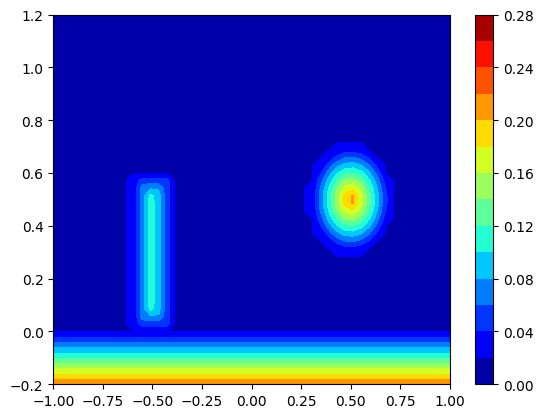

In [76]:
import matplotlib.pyplot as plt
levels = jnp.arange(0, 0.3, 0.02)
plt.contourf(X, Z, P, levels=levels, cmap='jet')
plt.colorbar()

In [23]:
p = jnp.array([0.5,0.5,0.6])
box(p, extents)

Array(0.10000002, dtype=float32)

In [15]:
q = jnp.abs(p) - extents
distance(np.maximum(q, 0))

Array(1.7320508, dtype=float32)

In [178]:
robot_points = jnp.array([
    [-0., 0, 0.],
    [-0.3, 0, 0.],
    [-0.4, 3, 0.]
])
robot_penetration_cost(robot_points, env, 0.3)

TypeError: penetration() missing 1 required positional argument: 'num_points'

In [150]:
point = jnp.array([0.,0,0])
jax.grad(penetration)(point, circ, 0.)

Array([ 1., -0., -0.], dtype=float32)